# Analysis of BALD scores during Training

In [ ]:
# hide
import blackhc.project.script
from nbdev.showdoc import *

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


## Train a simple model


In [ ]:
from typing import Optional

import torch
from ignite.contrib.engines.common import (
    add_early_stopping_by_val_score,
    setup_common_training_handlers,
)
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss, RunningAverage
from torch import nn

In [ ]:
from batchbald_redux.batchbald import get_bald_scores

In [ ]:
# experiment

import torch.utils.data

from batchbald_redux.black_box_model_training import get_predictions
from batchbald_redux.consistent_mc_dropout import (
    GeometricMeanPrediction,
    SamplerModel,
    geometric_mean_loss,
    multi_sample_loss,
)
from batchbald_redux.example_models import BayesianMNISTCNN
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.repeated_mnist import create_repeated_MNIST_dataset

train_dataset, test_dataset = create_repeated_MNIST_dataset(
    num_repetitions=1, add_noise=False
)

model = BayesianMNISTCNN()
train_model = SamplerModel(model, 1)
bald_model = SamplerModel(model, 20)
val_model = GeometricMeanPrediction(SamplerModel(model, 4))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

epochs_log = []
epoch_bald_scores = []

LOG_INTERVAL = 10

device = "cuda" if torch.cuda.is_available() else "cpu"

loss = multi_sample_loss(nn.NLLLoss())

# Move model to device before creating the optimizer
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=5e-4)

trainer = create_supervised_trainer(train_model, optimizer, loss, device=device)


def create_metrics(loss):
    return {"accuracy": Accuracy(), "crossentropy": Loss(loss)}


metrics = create_metrics(nn.NLLLoss())

validation_evaluator = create_supervised_evaluator(
    val_model, metrics=metrics, device=device
)


@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    validation_evaluator.run(test_loader)


# Only to look nicer.
RunningAverage(output_transform=lambda x: x).attach(trainer, "crossentropy")

setup_common_training_handlers(
    trainer, with_gpu_stats=torch.cuda.is_available(), log_every_iters=LOG_INTERVAL
)

ProgressBar(persist=False).attach(
    validation_evaluator,
    metric_names="all",
    event_name=Events.ITERATION_COMPLETED(every=LOG_INTERVAL),
)


# Logging
@validation_evaluator.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    metrics = dict(engine.state.metrics)
    epochs_log.append(metrics)

    predictions = get_predictions(model=bald_model, loader=test_loader, device=device)
    bald_scores = get_bald_scores(predictions.exp_(), dtype="double", device=device)
    epoch_bald_scores.append(bald_scores)


# Kick everything off
trainer.run(train_loader, max_epochs=10)

epochs_log

[{'accuracy': 0.9704, 'crossentropy': 0.171263622879982},
 {'accuracy': 0.9774, 'crossentropy': 0.13094418517686426},
 {'accuracy': 0.984, 'crossentropy': 0.1137340968646109},
 {'accuracy': 0.9853, 'crossentropy': 0.10771012411341072},
 {'accuracy': 0.984, 'crossentropy': 0.0990944158989936},
 {'accuracy': 0.9869, 'crossentropy': 0.09520312536023558},
 {'accuracy': 0.985, 'crossentropy': 0.0942817928135395},
 {'accuracy': 0.9863, 'crossentropy': 0.08745273601002991},
 {'accuracy': 0.9862, 'crossentropy': 0.0968733939472586},
 {'accuracy': 0.9868, 'crossentropy': 0.08672011169008911}]

In [ ]:
import plotnine as p9

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

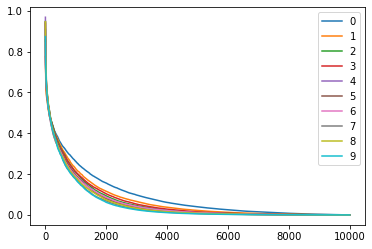

In [ ]:
fig = plt.figure()
ax = fig.subplots()

for i in range(len(epoch_bald_scores)):
    sorted_scores = torch.sort(epoch_bald_scores[i], descending=True)
    ax.plot(
        np.arange(len(sorted_scores.values)), sorted_scores.values.numpy(), label=str(i)
    )

ax.legend()

torch.return_types.sort(
values=tensor([7.8417e-01, 7.6331e-01, 7.4916e-01,  ..., 5.3502e-06, 4.2994e-06,
        4.2036e-06], dtype=torch.float64),
indices=tensor([2607, 4497, 4571,  ..., 4631, 5659,  981]))

In [ ]:
%config Completer.use_jedi=False

In [ ]:
sorted_scores

torch.return_types.sort(
values=tensor([7.8417e-01, 7.6331e-01, 7.4916e-01,  ..., 5.3502e-06, 4.2994e-06,
        4.2036e-06], dtype=torch.float64),
indices=tensor([2607, 4497, 4571,  ..., 4631, 5659,  981]))